In [41]:
# import libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import FunctionTransformer, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score,  make_scorer
from xgboost import XGBClassifier

%matplotlib inline

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

In [4]:
# load data
census = pd.read_csv('census.csv')
census.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,Female,0,3900,40,United-States,<=50K


In [5]:
# make a copy of the data
df = census.copy()

## Data Exploration and Cleaning

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education-num   32561 non-null  int64 
 5   marital-status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   sex             32561 non-null  object
 9   capital-gain    32561 non-null  int64 
 10  capital-loss    32561 non-null  int64 
 11  hours-per-week  32561 non-null  int64 
 12  native-country  32561 non-null  object
 13  income          32561 non-null  object
dtypes: int64(6), object(8)
memory usage: 3.5+ MB


In [7]:
df.shape

(32561, 14)

In [8]:
df.isna().sum()

age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
income            0
dtype: int64

In [9]:
# check which columns have '?'
cols = [col for col in df.columns if '?' in df[col].to_list()]
cols

['workclass', 'occupation', 'native-country']

In [10]:
# check if the number of ? is equal for affected columnns.
# They might be in the same index.
for i in range(len(cols)):
    print(df[cols[i-1]].value_counts()['?'] == df[cols[i]].value_counts()['?'])

# using list comprehension
[df[cols[i-1]].value_counts()['?'] == df[cols[i]].value_counts()['?'] for i in range(len(cols))]

False
False
False


[False, False, False]

The quantity of '?' is different

In [11]:
# check number & proportion of ? in affected columns
for i in cols:
    print(i, '\t', df[i].value_counts()['?'], '\t', str('{0:.2f}'.format((df[i].value_counts()['?']/df.shape[0])*100))+'%')

workclass 	 1836 	 5.64%
occupation 	 1843 	 5.66%
native-country 	 583 	 1.79%


In [12]:
# get index of affected columns
indices = []
for i in cols:
    indices.extend(df[df[i] == '?'].index)

indices = list(set(indices))
len(indices)

2399

In [13]:
# drop rows of the columns with '?'
df1 = df.drop(index=indices).reset_index(drop=True)

# check proportion of data left after dropping rows
"{:.2f}%".format(df1.shape[0]/df.shape[0] * 100)

'92.63%'

In [14]:
# examine data
df1.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,Female,0,4356,18,United-States,<=50K
1,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,Female,0,3900,40,United-States,<=50K
2,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,Female,0,3900,40,United-States,<=50K
3,34,Private,216864,HS-grad,9,Divorced,Other-service,Unmarried,Female,0,3770,45,United-States,<=50K
4,38,Private,150601,10th,6,Separated,Adm-clerical,Unmarried,Male,0,3770,40,United-States,<=50K


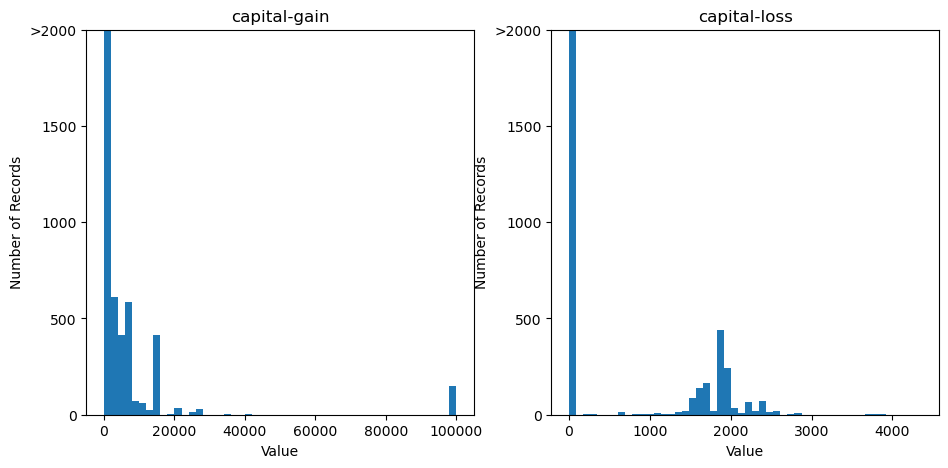

In [15]:
# examine capital-gain and capital-loss columns

fig = plt.figure(figsize = (11,5))

for i, feature in enumerate(['capital-gain','capital-loss']):
    ax = fig.add_subplot(1, 2, i+1)
    ax.hist(df1[feature], bins = 50)
    ax.set_title(f"{feature}")
    ax.set_xlabel("Value")
    ax.set_ylabel("Number of Records")
    ax.set_ylim((0, 2000))
    ax.set_yticks([0, 500, 1000, 1500, 2000])
    ax.set_yticklabels([0, 500, 1000, 1500, ">2000"])

## Data Preparation for Preprocessing

In [16]:
# divide columns
categorical = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'sex', 'native-country']
numerical= ['age','fnlwgt','education-num','capital-gain','capital-loss','hours-per-week']
capitals = ['capital-gain','capital-loss']

In [17]:
# split into features and target
X = df1.drop(['income'],axis= 1) # features
y = df1['income'] # target

In [18]:
# encode target
y = y.map({'<=50K': 0, '>50K': 1})

In [19]:
# custom functions in Pipeline transformation

def get_categorical_cols(X):
    return X[categorical]

def get_numerical_cols(X):
    return X[numerical]

def get_capital_cols(X):
    return X[capitals]

def log_transform_captitals(X):
    return X.apply(lambda x: np.log(x+1))

def get_dummies(X):
    return pd.get_dummies(X)

In [20]:
# Pipeline for capitals columns
capitals_pipeline = Pipeline([
    ('get_capitals', FunctionTransformer(get_capital_cols)),
    ('log_transformation',FunctionTransformer(log_transform_captitals))
])

# Pipeline for numerical columns
numerical_pipeline = Pipeline([
    ('get_numericals', FunctionTransformer(get_numerical_cols)),
    ('min_max_scaling', MinMaxScaler())
])

# Pipeline for categorical columns
categorical_pipeline = Pipeline([
    ('get_categoricals', FunctionTransformer(get_categorical_cols)),
    ('encoding (get_dummies)', FunctionTransformer(get_dummies))
])

In [21]:
# Bringing the pipelines together ...
steps_ = FeatureUnion([
    ('capital_pipeline', capitals_pipeline),
    ('numerical_pipeline', numerical_pipeline),
    ('categorical_pipeline', categorical_pipeline)
])

full_pipeline = Pipeline([('steps_', steps_)])

X = full_pipeline.fit_transform(df1)

In [22]:
# Split data into Train and Test set
seed = 42
x_train,x_test,y_train,y_test = train_test_split(X,y, stratify=y, test_size= 0.2, random_state=seed)

# The Models

In [23]:
# initialize classifier models

xgb = XGBClassifier(random_state= seed)


In [26]:
xgb.fit(x_train, y_train)
xgb_test_pred = xgb.predict(x_test)
xgb_train_pred = xgb.predict(x_train)

In [27]:
train_accuracy, train_f1_score = accuracy_score(y_train,xgb_train_pred), f1_score(y_train,xgb_train_pred)
test_accuracy, test_f1_score = accuracy_score(y_test, xgb_test_pred), f1_score(y_test, xgb_test_pred)

print('Metrics before optimization')
print('train_accuracy', train_accuracy)
print('train_f1_score', train_f1_score)
print('test_accuracy', test_accuracy)
print('test_f1_score', test_f1_score)

Metrics before optimization
train_accuracy 0.8996643043640433
train_f1_score 0.7840128468195201
test_accuracy 0.8741919443063153
test_f1_score 0.7252985884907709


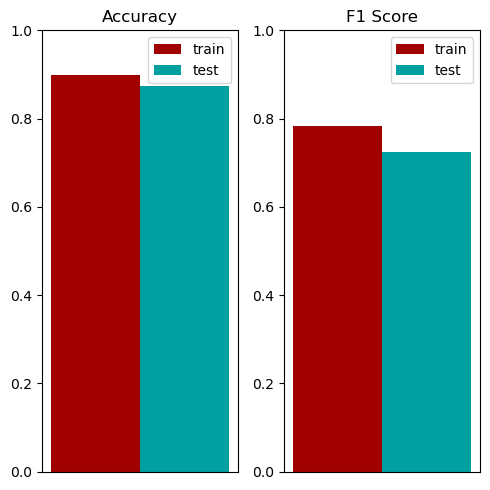

In [32]:
# Plot the metrics
def plot_metrics(train_accuracy, train_f1_score, test_accuracy, test_f1_score):
    bar_width = 0.3
    colors = ['#A00000', '#00A0A0']

    plt.figure(figsize=[5, 5])
    plt.subplot(1, 2, 1)
    plt.bar([1,1.3], [train_accuracy,test_accuracy], width=bar_width, color=colors, label=['train','test'])
    plt.ylim(0, 1)
    plt.xticks([])
#     plt.xlabel('Classifier')
#     plt.ylabel('ylabel')
    plt.title('Accuracy')
    plt.legend()
    
    plt.subplot(1,2,2)
    plt.bar([1,1.3], [train_f1_score,test_f1_score], width=bar_width, color=colors, label=['train','test'])
    plt.ylim(0, 1)
    plt.xticks([])
#     plt.xlabel('Classifier')
#     plt.ylabel('ylabel')
    plt.title('F1 Score')
    plt.legend()
    
    plt.tight_layout()
    plt.show()


plot_metrics(train_accuracy, train_f1_score, test_accuracy, test_f1_score)

### Optimization

In [33]:
# parameter grid for XGBoost
params = {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.05, 0.1],
        'min_child_weight': [5, 10],
        'gamma': [0.5, 1, 1.5,]
        }

xgb = XGBClassifier(random_state=seed)

scorer = make_scorer(f1_score)

xgb_grid_search = GridSearchCV(estimator= xgb, param_grid= params, scoring= scorer, cv=5, n_jobs=-1)
xgb_grid_search.fit(x_train, y_train)


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             n_jobs=-1,
             param_grid={'gamma': [0.5, 1, 1.5],
                         'learning_rate': [0.01, 0.05, 0.1],
                         'min_child_weight': [5, 10],
                         'n_estimators': [50, 100, 200]},
             scoring=make_scorer(f1_score))

In [34]:
# get the best params for xgboost
xgb_grid_search.best_params_

{'gamma': 0.5,
 'learning_rate': 0.1,
 'min_child_weight': 5,
 'n_estimators': 200}

In [37]:
# instatiate xgb boost with the best estimators
xgb_model_best = xgb_grid_search.best_estimator_

In [39]:
xgb_test_pred2 = xgb_model_best.predict(x_test)
xgb_train_pred2 = xgb_model_best.predict(x_train)

# Get metrics of the models after optimization
train_accuracy2, train_f1_score2 = accuracy_score(y_train,xgb_train_pred2), f1_score(y_train,xgb_train_pred2)
test_accuracy2, test_f1_score2 = accuracy_score(y_test, xgb_test_pred2), f1_score(y_test, xgb_test_pred2)

print('Metrics after optimization')
print('train_accuracy', train_accuracy2)
print('train_f1_score', train_f1_score2)
print('test_accuracy', test_accuracy2)
print('test_f1_score', test_f1_score2)

Metrics after optimization
train_accuracy 0.8849931617555639
train_f1_score 0.7499324141659909
test_accuracy 0.8746892093485827
test_f1_score 0.7246904588492352


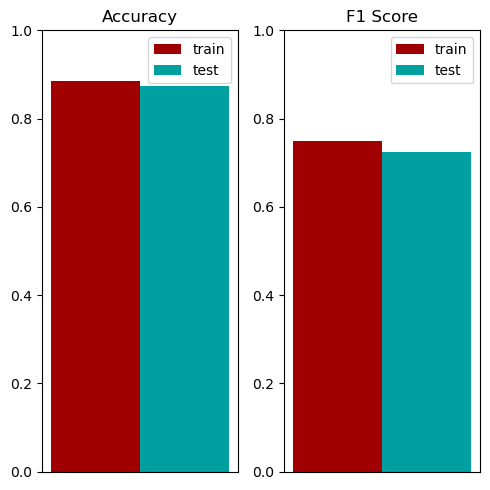

In [40]:
plot_metrics(train_accuracy2, train_f1_score2, test_accuracy2, test_f1_score2)


#### Results on the test set:

|     Metric     |     Before Optimization       |   After Optimization  | 
| :------------: | :---------------: | :-------------: | 
| Accuracy Score | 0.874            |     0.875      |
| F1 score        | 0.725            |     0.725      |  

